In [84]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from utils import merge_eeg_fmri
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Load fMRI data

In [85]:
offset = 10
sess=2
fmri_dmn = []
fmri_dan = []
for run in range(1,4):
    data_path = os.path.join(os.getcwd(),'eegfmri_data','sub-004')
    fmrifile_dmn = os.path.join(data_path,f'ses-00{sess}','func','ROI_percentSC',f'DMN_Standard_sub-004_ses-00{sess}_task-ExperienceSampling_run-00{run}_bold_MNI_percentSC.txt')
    fmrifile_dan = os.path.join(data_path,f'ses-00{sess}','func','ROI_percentSC',f'DAN_Standard_sub-004_ses-00{sess}_task-ExperienceSampling_run-00{run}_bold_MNI_percentSC.txt')
    fmri_dmn.append(np.loadtxt(fmrifile_dmn))
    fmri_dan.append(np.loadtxt(fmrifile_dan))

Assign train/val/test sets

In [86]:
X_train = fmri_dmn[0].reshape(-1,1) #reshape to samples x features
y_train = fmri_dan[0].reshape(-1,1)
X_valid = fmri_dmn[1].reshape(-1,1)
y_valid = fmri_dan[1].reshape(-1,1)
X_test = fmri_dmn[2].reshape(-1,1)
y_test = fmri_dan[2].reshape(-1,1)

Normalize with unit std

In [87]:
X_train = X_train/np.std(X_train)
y_train = y_train/np.std(y_train)
X_valid = X_valid/np.std(X_train)
y_valid = y_valid/np.std(y_valid)
X_test = X_test/np.std(X_train)
y_test = y_test/np.std(y_train)

In [88]:
y_train.shape
np.std(y_train)

1.0000000000000002

Convert data to PyTorch tensors

In [89]:
X_train_tensor = torch.tensor(X_train[np.newaxis,:,:], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[np.newaxis,:,:], dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid[np.newaxis,:,:], dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid[np.newaxis,:,:], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test[np.newaxis,:,:], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[np.newaxis,:,:], dtype=torch.float32)

Define parameters

In [90]:
input_channels = X_train_tensor.shape[2]  # Channels to used as input
output_channels = y_train_tensor.shape[2]  # Channels to be used as output
seq_length = X_train_tensor.shape[1]  # Length of each sequence
batch_size = 1 #we train with only one session
num_layers = 2 #perhaps 2 LSTM layers will do well (no need for more)
hidden_size = 24
learning_rate = 0.05 #perhaps this can be optimized
num_epochs = 250

Define LSTM model

In [91]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc(out[:, -1, :])  # Use only the last time step's output for prediction
        out = self.fc(out[:, :, :])  # all time step's output for prediction
        return out


Initialize the model, loss function, and optimizer

In [92]:
model = LSTMModel(input_channels, hidden_size, num_layers, output_channels)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   

Training loop

In [93]:
for epoch in range(num_epochs):

    # Forward pass
    out = model.forward(X_train_tensor)
    loss = criterion(out, y_train_tensor)  #MSELoss: o = np.mean(np.square(out.detach().numpy() - y_train_tensor.numpy()))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if epoch % 10 == 0:
        with torch.no_grad():
            out_valid = model.forward(X_valid_tensor)
            loss_valid = criterion(out_valid, y_valid_tensor) 
            print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Valid Loss: {loss_valid.item():.4f}")


Epoch: 0, Loss: 0.8161, Valid Loss: 0.9820
Epoch: 10, Loss: 0.7998, Valid Loss: 0.7835
Epoch: 20, Loss: 0.8049, Valid Loss: 0.7949
Epoch: 30, Loss: 0.7884, Valid Loss: 0.8037
Epoch: 40, Loss: 0.7495, Valid Loss: 0.8400
Epoch: 50, Loss: 0.7078, Valid Loss: 0.8546
Epoch: 60, Loss: 0.6582, Valid Loss: 0.9248
Epoch: 70, Loss: 0.6285, Valid Loss: 0.9164
Epoch: 80, Loss: 0.5632, Valid Loss: 0.9307
Epoch: 90, Loss: 0.5505, Valid Loss: 0.9542
Epoch: 100, Loss: 0.4538, Valid Loss: 0.9492
Epoch: 110, Loss: 0.3636, Valid Loss: 0.9611
Epoch: 120, Loss: 0.3039, Valid Loss: 0.9479
Epoch: 130, Loss: 0.2782, Valid Loss: 0.9921
Epoch: 140, Loss: 0.2041, Valid Loss: 0.9792
Epoch: 150, Loss: 0.1777, Valid Loss: 0.9843
Epoch: 160, Loss: 0.1449, Valid Loss: 0.9821
Epoch: 170, Loss: 0.1564, Valid Loss: 0.9744
Epoch: 180, Loss: 0.1109, Valid Loss: 0.9882
Epoch: 190, Loss: 0.1024, Valid Loss: 0.9964
Epoch: 200, Loss: 0.0950, Valid Loss: 0.9870
Epoch: 210, Loss: 0.0798, Valid Loss: 0.9841
Epoch: 220, Loss: 0.0

Plot fit for train data

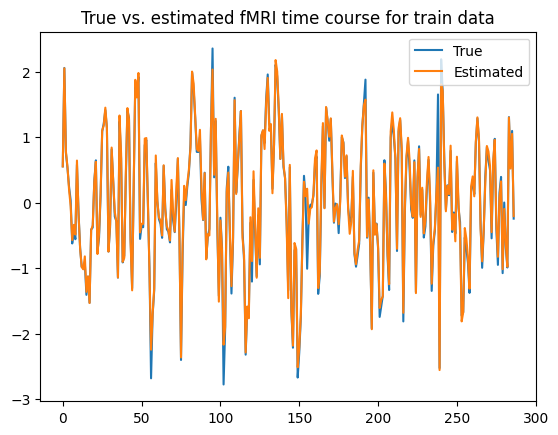

In [94]:
plt.figure()
plt.title('True vs. estimated fMRI time course for train data')
plt.plot(y_train_tensor[:,:,0].numpy().transpose()) #plot true train time course
plt.plot(out[:,:,0].detach().numpy().transpose()) #plot estimated time course
plt.legend(['True','Estimated'])
plt.show()

Plot fit for validation data

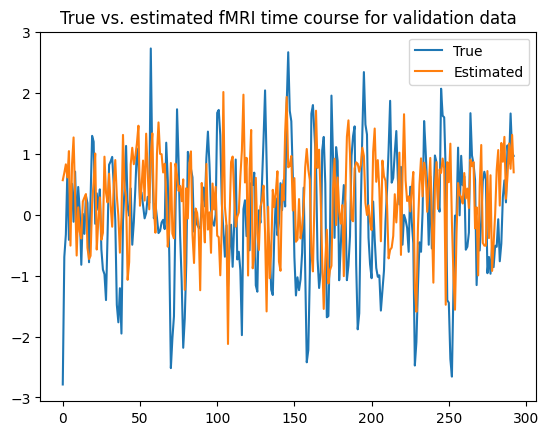

In [95]:
plt.figure()
plt.title('True vs. estimated fMRI time course for validation data')
plt.plot(y_valid_tensor[:,:,0].numpy().transpose()) #plot true train time course
plt.plot(out_valid[:,:,0].detach().numpy().transpose()) #plot estimated time course
plt.legend(['True','Estimated'])
plt.show()